# Today we will continue to practice ML pipeline on COVID-19 CXR radiomics dataset that we explored in Problem Set 1

### Warning: This notebook will take a while to run because we have >2,500 features

## Import the library
Note that we are using **UMAP** here

In [113]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, roc_curve, classification_report

import tensorflow as tf
import tensorflow.keras.layers as layers

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import Model, Sequential

## Load clinical data

In [2]:
clinical_data = pd.read_excel('L11.1_clinical_data.xlsx', header = 0, index_col = 0)
clinical_data.head(10)

,Class,CT,WBC,L_number,N_number,Platelet
Patient ID,,,,,,
1,Positive,12.89,5310.0,960.0,3660.0,131000.0
2,Positive,26.76,2800.0,1030.0,1170.0,89000.0
3,Positive,26.39,4170.0,1030.0,2800.0,138000.0
5,Positive,30.06,5460.0,1810.0,3160.0,231000.0
6,Positive,26.28,8220.0,1390.0,6390.0,208000.0
7,Positive,25.42,5690.0,1450.0,3950.0,189000.0
8,Positive,26.86,3460.0,920.0,2190.0,118000.0
9,Positive,21.01,7280.0,1820.0,4930.0,201000.0
10,Positive,NaN,5270.0,1430.0,3440.0,249000.0


## Create label data for COVID-19 classification
Use **DataFrame.astype(int)** to convert True/False to 1/0

In [3]:
covid_label = (clinical_data['Class'] == 'Positive').astype(int)
covid_label.head()

Patient ID
1    1
2    1
3    1
5    1
6    1
Name: Class, dtype: int64

## Load radiomics data for 6 lung regions
We create a dictionary to store the individual lung region's data

In [37]:
lung_regions = ['lower_left', 'mid_left', 'upper_left', 'lower_right', 'mid_right', 'upper_right']
data_raw = {}

for r in lung_regions:
    data_raw[r] = pd.read_csv('L11.1_' + r + '_lung_radiomics.csv', header = 0, index_col = 0)
    
data_raw['lower_left'].head()

,original_shape2D_Elongation,original_shape2D_MajorAxisLength,original_shape2D_MaximumDiameter,original_shape2D_MeshSurface,original_shape2D_MinorAxisLength,original_shape2D_Perimeter,original_shape2D_PerimeterSurfaceRatio,original_shape2D_PixelSurface,original_shape2D_Sphericity,original_firstorder_10Percentile,...,wavelet-LL_gldm_LargeDependenceLowGrayLevelEmphasis,wavelet-LL_gldm_LowGrayLevelEmphasis,wavelet-LL_gldm_SmallDependenceEmphasis,wavelet-LL_gldm_SmallDependenceHighGrayLevelEmphasis,wavelet-LL_gldm_SmallDependenceLowGrayLevelEmphasis,wavelet-LL_ngtdm_Busyness,wavelet-LL_ngtdm_Coarseness,wavelet-LL_ngtdm_Complexity,wavelet-LL_ngtdm_Contrast,wavelet-LL_ngtdm_Strength
ID,,,,,,,,,,,,,,,,,,,,,
1,0.764978,157.631361,184.370493,14088.86354,120.584500,529.277862,0.037567,14088.87320,0.794985,-0.750019,...,0.013489,0.000611,0.140209,726.296035,0.000078,0.363703,0.000273,2710.866852,0.036529,1.871671
2,0.688672,177.563823,208.502456,16217.43879,122.283254,576.017986,0.035518,16217.44845,0.783718,-0.935750,...,0.008966,0.000599,0.177496,1112.631326,0.000107,0.474238,0.000192,3369.767187,0.054712,1.507828
3,0.670128,156.781103,180.350023,12194.72930,105.063410,507.562532,0.041621,12194.73897,0.771261,-0.483610,...,0.006129,0.000372,0.145532,891.833985,0.000059,0.344083,0.000271,3115.266473,0.031005,1.890196
5,0.698556,164.394142,189.408043,14042.43518,114.838515,535.634745,0.038144,14042.44484,0.784255,-1.005184,...,0.014026,0.000706,0.125656,678.216878,0.000092,0.308843,0.000377,2379.703718,0.051951,2.367572
6,0.680535,145.326831,171.457782,10557.31320,98.900031,468.895981,0.044414,10557.32286,0.776793,0.326019,...,0.001986,0.000203,0.255015,2080.056579,0.000057,0.385421,0.000183,5216.631799,0.035996,1.805214


## Standardize each feature

In [38]:
temp = pd.concat([data_raw[r] for r in lung_regions], axis = 0)
feature_mean = temp.mean(axis = 0)
feature_std = temp.std(axis = 0)

feature_mean.head()

original_shape2D_Elongation             0.693411
original_shape2D_MajorAxisLength      149.175407
original_shape2D_MaximumDiameter      165.719558
original_shape2D_MeshSurface        15984.437108
original_shape2D_MinorAxisLength      102.810089
dtype: float64

In [39]:
data_std = {}

for r in lung_regions:
    data_std[r] = (data_raw[r] - feature_mean) / feature_std

## Reshape data from 6 lung regions for each sample into a 3x2 matrix

In [40]:
num_sample, num_feature = data_std['lower_left'].shape
data_merged = np.zeros([num_sample, 3, 2, num_feature])

for i in range(num_sample):
    data_merged[i, 0, 0, :] = data_std['upper_left'].iloc[i, :]
    data_merged[i, 1, 0, :] = data_std['mid_left'].iloc[i, :]
    data_merged[i, 2, 0, :] = data_std['lower_left'].iloc[i, :]
    
    data_merged[i, 0, 1, :] = data_std['upper_right'].iloc[i, :]
    data_merged[i, 1, 1, :] = data_std['mid_right'].iloc[i, :]
    data_merged[i, 2, 1, :] = data_std['lower_right'].iloc[i, :]

print('merged data dimension:', data_merged.shape)

merged data dimension: (562, 3, 2, 464)


## Split data into 60:20:20 proportion

In [41]:
X_train, X_test, y_train, y_test = train_test_split(data_merged, covid_label, test_size = 0.2, stratify = covid_label, \
                                                    shuffle = True, random_state = 3011979)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, stratify = y_train, \
                                                    shuffle = True, random_state = 3011979) 

In [47]:
print(X_train.shape)
print(y_train.shape)

(359, 3, 2, 464)
(359,)


## Define a CNN model

In [193]:
def create_cnn():
    model = Sequential()
    model.add(layers.InputLayer(input_shape = [3, 2, 464]))
    
    model.add(layers.Conv2D(filters = 64, kernel_size = [1, 1]))
    model.add(layers.Activation(activation = 'relu'))

    model.add(layers.Dropout(0.2))
    
    model.add(layers.AveragePooling2D())
    
    model.add(layers.Flatten())
    model.add(layers.Dense(units = 1, activation = 'sigmoid'))
    
    return model

In [194]:
custom_model = create_cnn()
custom_model.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_47 (Conv2D)           (None, 3, 2, 64)          29760     
_________________________________________________________________
activation_45 (Activation)   (None, 3, 2, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 2, 64)          0         
_________________________________________________________________
average_pooling2d_7 (Average (None, 1, 1, 64)          0         
_________________________________________________________________
flatten_23 (Flatten)         (None, 64)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 65        
Total params: 29,825
Trainable params: 29,825
Non-trainable params: 0
_________________________________________________

## Compile and train the model

In [195]:
custom_model.compile(loss = 'binary_crossentropy', optimizer = Adam(learning_rate = 1e-5), \
                     metrics = ['accuracy'])

checkpoint = ModelCheckpoint('L12_radiomics/cnn_model.ckpt', \
                             save_best_only = True, \
                             save_weights_only = True, \
                             verbose = 1)

reduce_lr = ReduceLROnPlateau(patience = 20, factor = 0.2)

In [196]:
history = custom_model.fit(X_train, y_train, validation_data = (X_val, y_val), batch_size = 32, \
                           epochs = 100, verbose = 1, callbacks = [checkpoint, reduce_lr])

Epoch 1/100
12/12 [==============================] - 1s 16ms/step - loss: 0.7302 - accuracy: 0.6391 - val_loss: 0.6704 - val_accuracy: 0.7111

Epoch 00001: val_loss improved from inf to 0.67036, saving model to covid19_radiomics/cnn_model.ckpt
Epoch 2/100
12/12 [==============================] - 0s 11ms/step - loss: 0.7138 - accuracy: 0.6315 - val_loss: 0.6647 - val_accuracy: 0.7222

Epoch 00002: val_loss improved from 0.67036 to 0.66465, saving model to covid19_radiomics/cnn_model.ckpt
Epoch 3/100
12/12 [==============================] - 0s 10ms/step - loss: 0.6754 - accuracy: 0.6637 - val_loss: 0.6600 - val_accuracy: 0.6889

Epoch 00003: val_loss improved from 0.66465 to 0.66001, saving model to covid19_radiomics/cnn_model.ckpt
Epoch 4/100
12/12 [==============================] - 0s 8ms/step - loss: 0.6819 - accuracy: 0.6610 - val_loss: 0.6560 - val_accuracy: 0.6889

Epoch 00004: val_loss improved from 0.66001 to 0.65603, saving model to covid19_radiomics/cnn_model.ckpt
Epoch 5/100
1

12/12 [==============================] - 0s 12ms/step - loss: 0.6021 - accuracy: 0.6780 - val_loss: 0.6145 - val_accuracy: 0.7000

Epoch 00034: val_loss improved from 0.61534 to 0.61455, saving model to covid19_radiomics/cnn_model.ckpt
Epoch 35/100
12/12 [==============================] - 0s 9ms/step - loss: 0.5873 - accuracy: 0.7100 - val_loss: 0.6142 - val_accuracy: 0.7111

Epoch 00035: val_loss improved from 0.61455 to 0.61421, saving model to covid19_radiomics/cnn_model.ckpt
Epoch 36/100
12/12 [==============================] - 0s 12ms/step - loss: 0.5516 - accuracy: 0.7392 - val_loss: 0.6129 - val_accuracy: 0.7111

Epoch 00036: val_loss improved from 0.61421 to 0.61293, saving model to covid19_radiomics/cnn_model.ckpt
Epoch 37/100
12/12 [==============================] - 0s 12ms/step - loss: 0.5584 - accuracy: 0.7375 - val_loss: 0.6117 - val_accuracy: 0.7111

Epoch 00037: val_loss improved from 0.61293 to 0.61166, saving model to covid19_radiomics/cnn_model.ckpt
Epoch 38/100
12/12

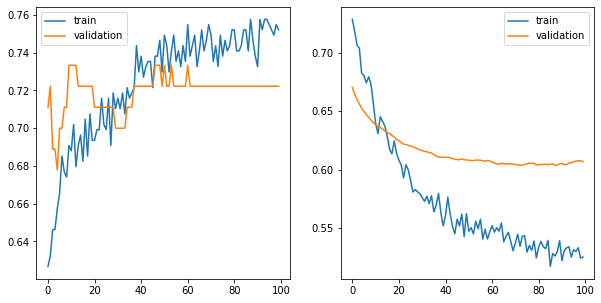

In [197]:
plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'validation')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'validation')
plt.legend()

plt.show()

In [186]:
y_val_pred = custom_model.predict(X_val)
print(classification_report(y_val, y_val_pred > 0.5, target_names = ['Normal', 'COVID-19']))

              precision    recall  f1-score   support

      Normal       0.70      0.98      0.82        63
    COVID-19       0.50      0.04      0.07        27

    accuracy                           0.70        90
   macro avg       0.60      0.51      0.45        90
weighted avg       0.64      0.70      0.60        90



In [140]:
y_test_pred = custom_model.predict(X_test)
print(classification_report(y_test, y_test_pred > 0.5, target_names = ['Normal', 'COVID-19']))

              precision    recall  f1-score   support

      Normal       0.74      0.87      0.80        79
    COVID-19       0.50      0.29      0.37        34

    accuracy                           0.70       113
   macro avg       0.62      0.58      0.59       113
weighted avg       0.67      0.70      0.67       113



## ROC curve

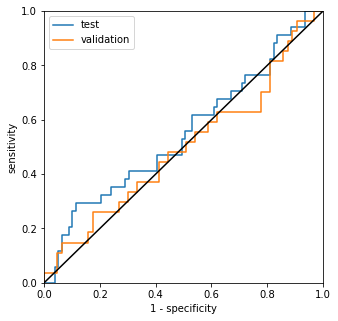

In [141]:
plt.figure(figsize = (5, 5))
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
plt.plot(fpr, tpr, c = 'tab:blue', label = 'test')
    
fpr, tpr, thresholds = roc_curve(y_val, y_val_pred)
plt.plot(fpr, tpr, c = 'tab:orange', label = 'validation')

plt.plot([0, 1], [0, 1], 'k')
plt.xlabel('1 - specificity'); plt.ylabel('sensitivity')
plt.axis([0, 1, 0, 1])
plt.legend()
plt.show()